In [1]:
import numpy as np
import pandas as pd
from os import path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

## Download data

In [2]:
data = pd.read_csv(path.join('data','loan_data.csv'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Prepare data

In [3]:
# make target varible a credtit.policy and drop it from the data
target = data['credit.policy']
data['log.revol.bal'] = np.log(data['revol.bal'])
data = data.drop('revol.bal', axis=1)

# separate the data into numerical and categorical
numerical = data.select_dtypes(include=[np.number])
categorical = data.select_dtypes(include=[object])

/Users/valeriichuiko/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='credit.policy'>

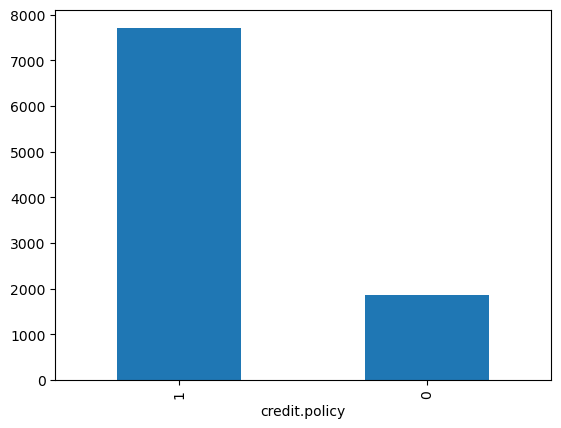

In [4]:
# plot count of target variable
target.value_counts().plot(kind='bar')

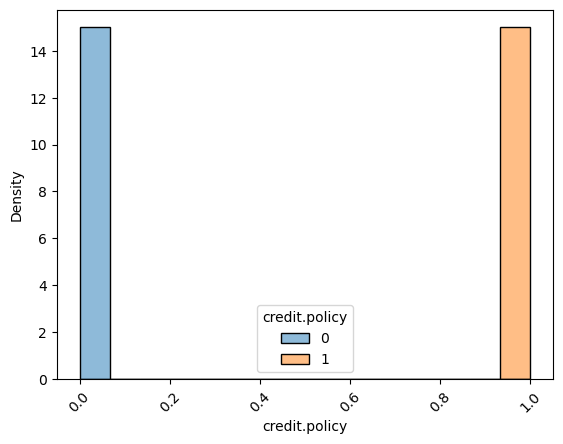

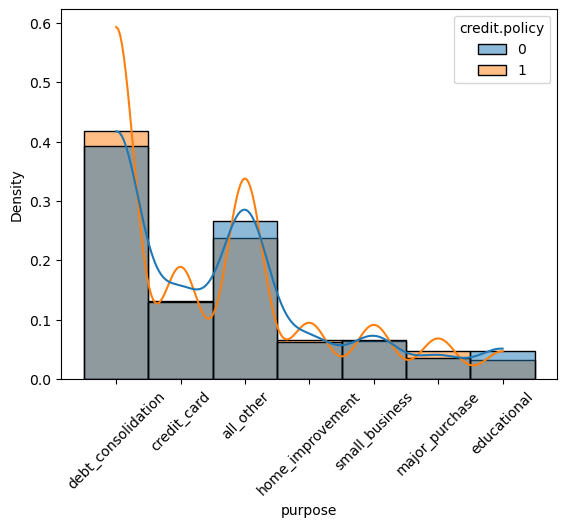

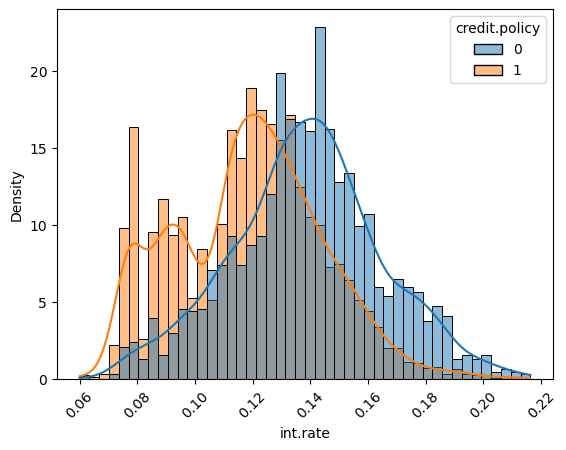

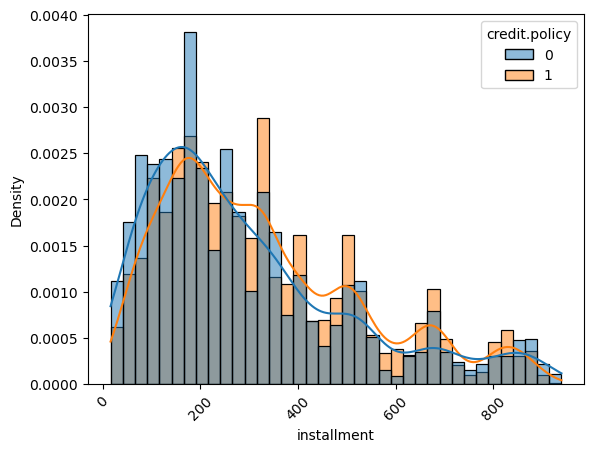

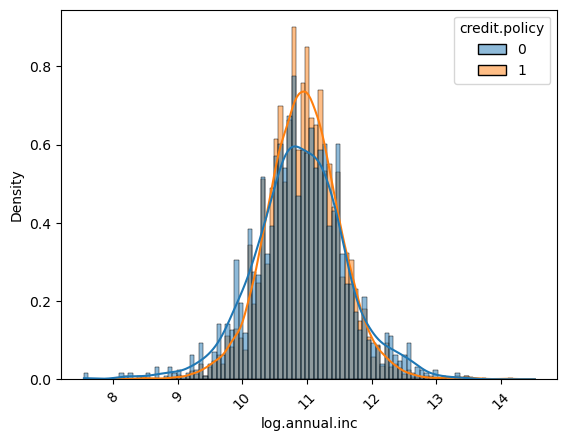

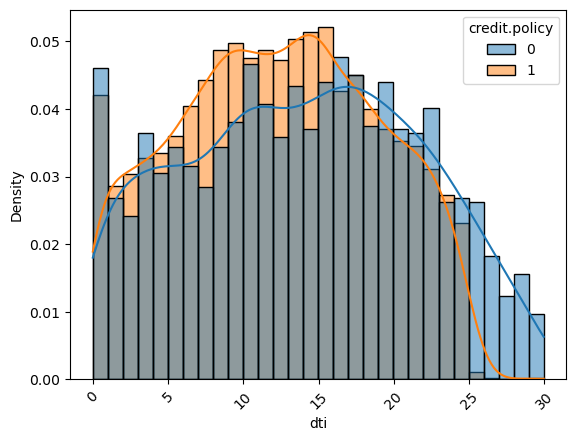

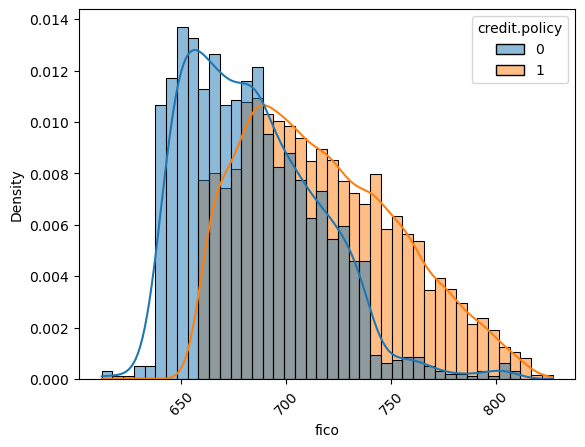

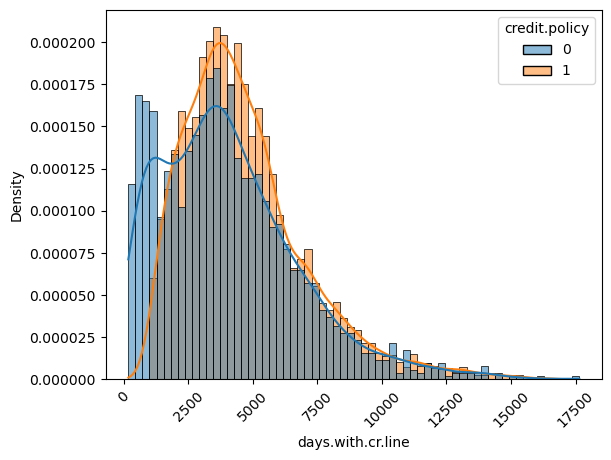

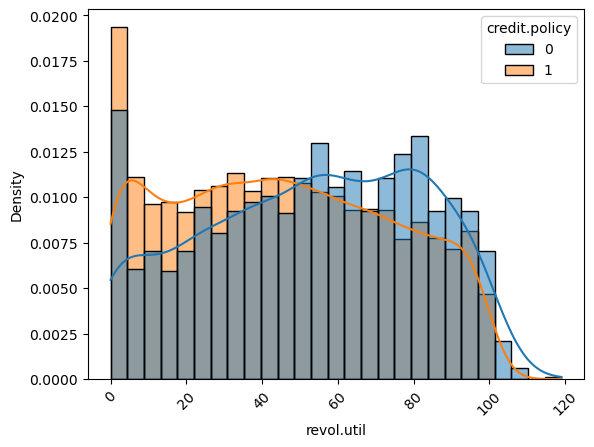

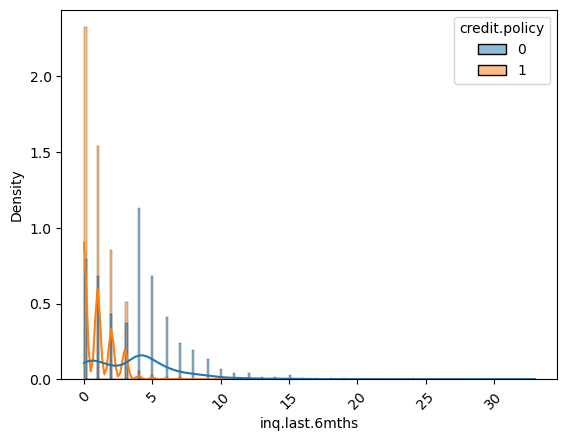

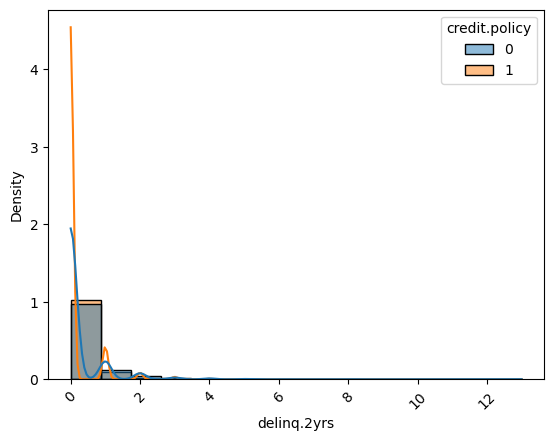

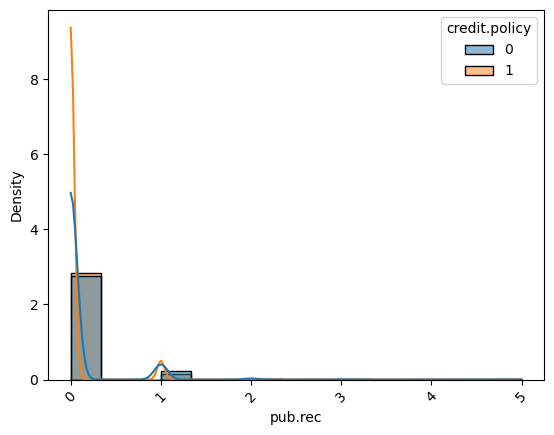

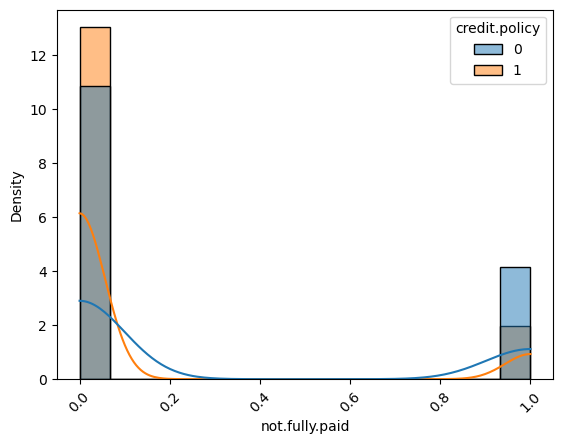

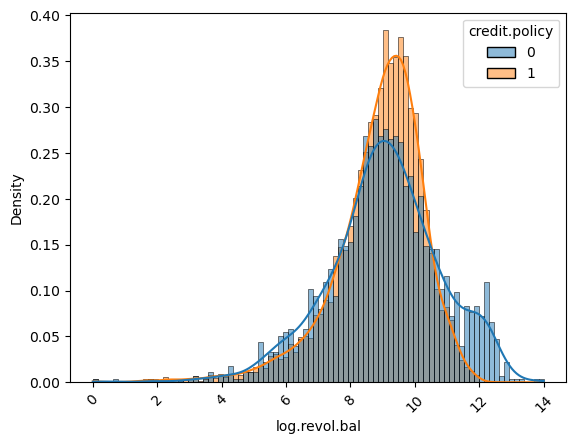

In [5]:
# plot distribution of numerical data
# for each value of target 1 or 0
for column in data:
    sns.histplot(data=data, x=column, hue=target, stat='density', common_norm=False, kde=True)
    plt.xticks(rotation=45)
    plt.show()

From the plots above it looks like there are few notable features that can be used to predict the target variable. The features that are most likely to be useful are:
- interest rate. The higher the interest rate, the higher the probability of default (separates around 0.13).
- debt to income ratio. There is a clear separation around the tail of >25
- fico. The less the fico score, the higher the probability of default (separates around 1000).
- revol.util. The higher the revolving utilization, the higher the probability of default (separates around 60).
- inq.last.6mths. The higher the number of inquiries, the higher the probability of default (separates around 4).
- log.revol.bal. The higher the revolving balance, the higher the probability of default (separates around 11).

<Axes: >

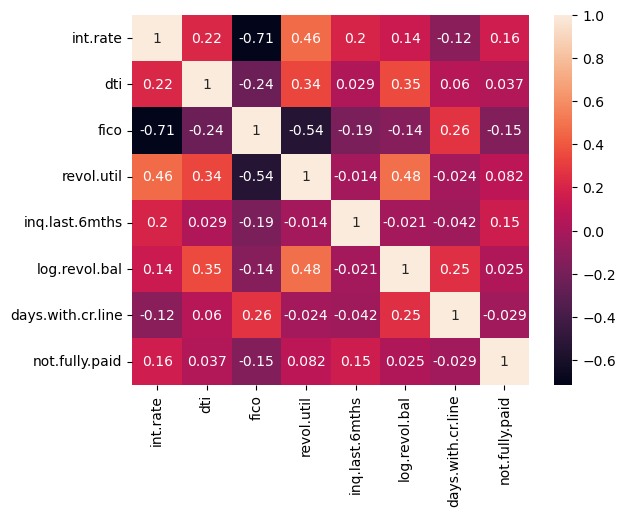

In [6]:
# to make sure interesting columns are not correlated
# plot correlation plots for selected columns
column_names = ['int.rate', 'dti', 'fico', 'revol.util', 'inq.last.6mths', 'log.revol.bal', 'days.with.cr.line', 'not.fully.paid']
correration_matrix = data[column_names].corr()
sns.heatmap(correration_matrix, annot=True)

In [7]:
# make categorial values into one-hot encoding
categorical = OneHotEncoder().fit_transform(categorical).todense()
# scale the numerical values
numerical['revol.bal'] = np.exp(numerical['log.revol.bal'])
numerical = numerical.drop('log.revol.bal', axis=1)

column_names.remove('log.revol.bal')
column_names.append('revol.bal')
numerical = StandardScaler().fit_transform(numerical[column_names])

# combine the numerical and categorical data
X = np.hstack([numerical, categorical])
y = target

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y))

## Predicting the target variable

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(class_weight='balanced')
# weight classes to balance the data
# weights are chosen to be inversely proportional to the class frequencies
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Note: recal with class reweightig shows better results

              precision    recall  f1-score   support

           0       0.57      0.84      0.68       429
           1       0.96      0.86      0.91      1966

    accuracy                           0.86      2395
   macro avg       0.76      0.85      0.79      2395
weighted avg       0.89      0.86      0.87      2395



In [21]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Report for Decision Tree: \n", classification_report(y_test, y_pred))

# Random forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
model = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=30, random_state=0, bootstrap=True, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Report for Random Forest: \n", classification_report(y_test, y_pred))

# Gradient boosting
model = GradientBoostingClassifier(n_estimators=200, max_depth=30, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Report for Gradient Boosting: \n", classification_report(y_test, y_pred))

# XGBoost
from xgboost import XGBClassifier
model = XGBClassifier(class_weight='balanced', n_estimators=200, max_depth=20, random_state=0, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Report for XGBoost: \n", classification_report(y_test, y_pred))




Report for Decision Tree: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       429
           1       0.99      0.99      0.99      1966

    accuracy                           0.98      2395
   macro avg       0.97      0.97      0.97      2395
weighted avg       0.98      0.98      0.98      2395

Report for Random Forest: 
               precision    recall  f1-score   support

           0       0.98      0.93      0.96       429
           1       0.98      1.00      0.99      1966

    accuracy                           0.98      2395
   macro avg       0.98      0.96      0.97      2395
weighted avg       0.98      0.98      0.98      2395

Report for Gradient Boosting: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       429
           1       0.99      0.99      0.99      1966

    accuracy                           0.98      2395
   macro avg       0.97      0.97      0

/Users/valeriichuiko/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:39:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Report for XGBoost: 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       429
           1       0.99      1.00      0.99      1966

    accuracy                           0.99      2395
   macro avg       0.99      0.97      0.98      2395
weighted avg       0.99      0.99      0.99      2395



In [25]:
## Fine tuning the Gradient Boosting model

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.1, 0.01, 0.001]
}

model = GradientBoostingClassifier(random_state=0)
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='recall_weighted')
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Best estimator: ", grid_search.best_estimator_)
y_pred = grid_search.predict(X_test)
print("Report for Gradient Boosting after fine tuning: \n", classification_report(y_test, y_pred))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
Best score:  0.9855212143092595
Best estimator:  GradientBoostingClassifier(max_depth=10, n_estimators=300, random_state=0)
Report for Gradient Boosting after fine tuning: 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       429
           1       0.99      1.00      0.99      1966

    accuracy                           0.99      2395
   macro avg       0.99      0.97      0.98      2395
weighted avg       0.99      0.99      0.99      2395

